## Import libraries

In [1]:
import sys
import numpy as np
import pandas as pd
from os.path import abspath, join as opj
from scipy.spatial.distance import cdist

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import analysis helpers

In [2]:
sys.path.insert(0, abspath('../../helpers/'))
from analysis_helpers import RECALL_WSIZE

Functions and variables used across multiple notebooks can be found [here](https://github.com/contextlab/sherlock-topic-model-paper/blob/master/code/helpers/analysis_helpers.py)

## Define some functions

In [3]:
def get_event_text(event_boundaries, kind='video', sub=None):
    if kind == 'video':
        onset, offset = event_boundaries
        video_text_slice = video_text.loc[(video_text['Start Time (TRs, 1.5s)'] >= onset) 
                                          & (video_text['End Time (TRs, 1.5s)'] < offset),
                                         'Scene Details - A Level ']
        text_slice = ' '.join(video_text_slice)
    elif kind == 'recall':
        if sub is None:
            raise ValueError('must pass subject identifier if kind == "recall"')
        curr_sentences = parse_recall_sentences(event_boundaries, sub=sub)
        text_slice = '.'.join(curr_sentences) + '.'
    else:
        raise ValueError('kind must be either "video" or "recall"')
    return text_slice


def parse_recall_sentences(event_boundaries, sub):
    onset, offset = event_boundaries
    transcript_path = opj(rawdir, f'NN{sub} transcript.txt')
    with open(transcript_path, 'r', encoding='cp1252') as f:
        transcript = f.read().replace(b'\x92'.decode('cp1252'), "'").strip()

    textlist = transcript.split('.')
    windows = []
    window_n = 0
    for w_ix in range(1, RECALL_WSIZE):
        if onset <= window_n <= offset:
            start, end = 0, w_ix
            windows.append('.'.join(textlist[start : end]))
        window_n += 1
    for w_ix in range(len(textlist)):
        if onset <= window_n <= offset:
            start = w_ix
            end = w_ix + RECALL_WSIZE if w_ix + RECALL_WSIZE <= len(textlist) else len(textlist)
            windows.append('.'.join(textlist[start : end]))
        window_n += 1
    full_reclist = '.'.join(windows).split('.')
    recall_text_slice = pd.unique(full_reclist)
    return '.'.join(recall_text_slice).strip().split('.')

## Settings and parameters

In [4]:
rawdir = '../../../data/raw'
datadir = '../../../data/processed/'
figdir = '../../../paper/figs/'
sns.set_context('paper')
sns.set_style('ticks')
sns.set_palette('hls', 17)
mpl.rcParams['pdf.fonttype'] = 42

## Load data

In [5]:
video_events = np.load(opj(datadir, 'video_events.npy'), allow_pickle=True)
recall_events = np.load(opj(datadir, 'recall_events.npy'), allow_pickle=True)

video_event_times = np.load(opj(datadir, 'video_event_times.npy'), allow_pickle=True)
recall_event_times = np.load(opj(datadir, 'recall_event_times.npy'), allow_pickle=True)

video_text = pd.read_excel('../../../data/raw/Sherlock_Segments_1000_NN_2017.xlsx')
recall_text = np.load(opj(datadir, 'recall_text.npy'), allow_pickle=True)

matches = np.load(opj(datadir, 'labels.npy'), allow_pickle=True)

## Compute precision

In [6]:
precision_df = pd.DataFrame(index=range(len(recall_events)), columns=range(video_events.shape[0]))
for sub, rec in enumerate(recall_events):
    sub_matches = matches[sub]
    matched_events = video_events[sub_matches]
    sub_prec = np.diag(1 - cdist(rec, matched_events, 'correlation'))
    for p, vid_event in zip(sub_prec, sub_matches):
        # use only the best recall event for each video event
        if p < precision_df.loc[sub, vid_event]:
            continue
        precision_df.loc[sub, vid_event] = p

In [7]:
ranked_order = precision_df.mean(axis=0).argsort()[::-1]
ranked_order += 1
precision_df.index.set_names('Participant', inplace=True)
precision_df.reset_index(inplace=True)
precision_df['Participant'] = precision_df['Participant'].apply(lambda p: f'P{p + 1}')
precision_df = precision_df.melt(id_vars=['Participant'], var_name='Video event', value_name='Precision')
precision_df['Precision'] = precision_df['Precision'].astype(np.float64)
precision_df['Video event'] += 1

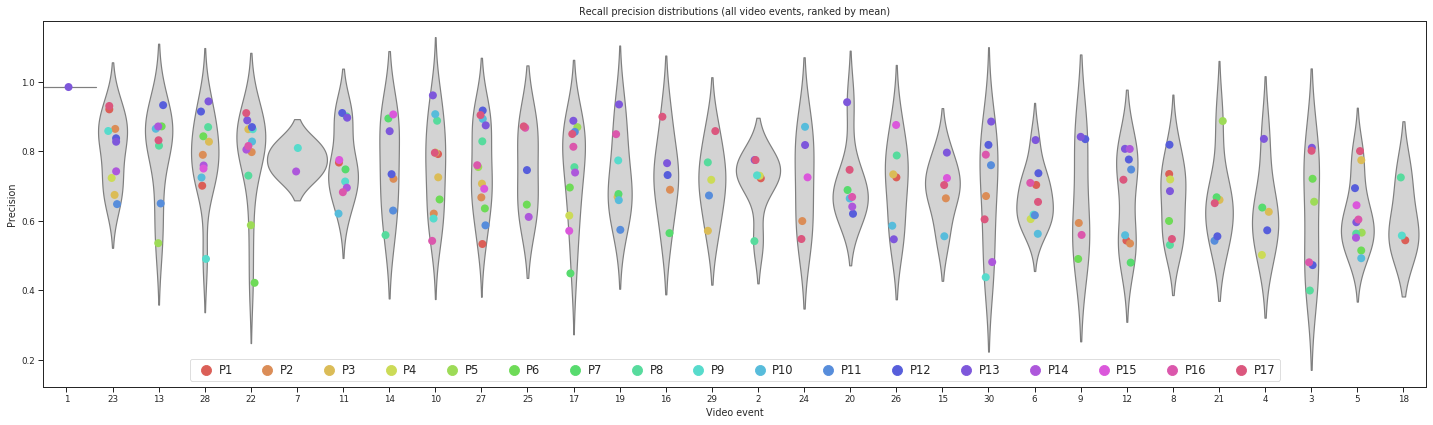

In [8]:
# fig, ax = plt.subplots(1)
# fig.set_size_inches(20, 6)
g = sns.catplot(x='Video event', y='Precision', data=precision_df, kind='violin',
                order=ranked_order, width=1.3, color='lightgrey', inner=None)
g.fig.set_size_inches(20, 6)
sns.stripplot(x='Video event', y='Precision', hue='Participant', data=precision_df, 
              order=ranked_order, size=8, ax=g.ax)

hs, ls = g.ax.get_legend_handles_labels()
g.ax.legend_.remove()
g.ax.legend(hs, ls, loc='lower center', ncol=17, handletextpad=.1, fontsize='large', markerscale=1.3)
for sp in g.ax.spines.values():
    sp.set_visible(True)
plt.title('Recall precision distributions (all video events, ranked by mean)')
plt.tight_layout()
# plt.savefig(opj(figdir, 'tmp', 'precision_detail_vid_all.pdf'))
plt.show()

In [9]:
prec_ranges = precision_df.groupby('Video event')['Precision'].agg(np.ptp)
max_diff_event = prec_ranges.idxmax()
max_diff_precs = precision_df.loc[precision_df['Video event'] == max_diff_event]
high_rec = max_diff_precs.loc[max_diff_precs['Precision'].idxmax(), 'Participant']
low_rec = max_diff_precs.loc[max_diff_precs['Precision'].idxmin(), 'Participant']

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [10]:
print(f'video event: {max_diff_event}\n', 
      f'most precise: {high_rec}\n', 
      f'least precise: {low_rec}')

video event: 22
 most precise: P17
 least precise: P6


In [11]:
video_bounds = video_event_times[max_diff_event - 1]
high_rec_bounds = np.array(recall_event_times[16])[matches[16] == max_diff_event - 1][0]
low_rec_bounds = np.array(recall_event_times[5])[matches[5] == max_diff_event - 1][0]

In [12]:
video_event_text = get_event_text(video_bounds, kind='video')
high_rec_text = get_event_text(high_rec_bounds, kind='recall', sub=17)
low_rec_text = get_event_text(low_rec_bounds, kind='recall', sub=6)

In [13]:
video_event_text

'Donovan turns around toward John and calls out to John: "Stay away from Sherlock Holmes" John watches her go, then looks around for a moment.  John turns and eyes the distance he has to go to get to the main road.  John begins to limp down the road. He is looking up toward his left. The sound of a telephone ringing is heard and John stops walking.  John turns to where the sound is coming from. It is from a public telephone in a red booth. He looks at it for a few seconds.  John looks down at his watch, shakes his head and continues down the road.  A view of the telephone booth. It stops ringing as John starts walking away.  Not long afterwards, John is walking down the main road. He tries to hail a passing taxi. John yells out: "Taxi! Taxi…" The taxi passes him by In Chicken Cottage, the fast food restaurant outside which John is stand, the payphone on the wall begins to ring. John turns and looks as one of the serving staff walks over to it but as he reaches for the phone, it stops. 

In [14]:
high_rec_text

"This was before Watson walked up to her. So, then Watson, Watson, but then she tells him Oh if you just go to the main road you can find a cab. So then he's walking away. But then she calls out to him, How do you know Sherlock? And he's like, I just met him. He's no my friend. And she's like, well stay away from him, because he's dangerous. She tells Watson that she thinks he's a psych-, she thinks Sherlock is a psychopath. Because he gets off on these murder crime scenes and figuring stuff out, and that, while none of them have been linked to him, she thinks that eventually they're gonna find one of these bodies and it's, he woulda, he's gonna have been the one that put it there. So then we see, right, kinda like across the street from the building where that lady was found dead, there was this red telephone booth. And it was ringing. Which is weird, and then Watson looks at it and hears it ringing but chooses not to answer it. So then he just ends up walking, we see him walking like

In [15]:
low_rec_text

"But the bag disappears, he figures it is pink just like her suit, her sportcoat.   He asks Watson to examine the body and Watson says it looks like strangling or asphyxiation, she doesn't seem drunk.   Oh and before the show we see the same pills in a container on the floor and we've just seen a woman's hand reaching down for them but we did not see the woman.   So we had some advanced warning of this additional death.  Sherlock ends up kind of running out of the room he has a eureka moment about the first mistake that the--first of all he says he thinks they are murders not suicides, that they have a serial killer on their hands, and he has a eureka moment, he gets really caught up and excited, and he runs off to find the suitcase leaving Watson alone. Watson comes out of the building and asks the female police detective earlier where he can find a cab.  And she warns him about getting too close to Sherlock because Sherlock doesn't have any friends and is kind of psychopathic in his 